## Advanced Modeling Approach

To tackle the complex challenge of predicting credit default in a real-world, time-sensitive setting, an advanced supervised learning framework was implemented. Multiple classification algorithms—including Random Forest, XGBoost, Decision Tree, and Logistic Regression—were trained and validated on processed behavioral and customer profile data. 

In [60]:
#Importing Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Check current working directory and file existence

print(f"Current working directory: {os.getcwd()}")
train_file = "processed_train_data.csv"
test_file = "processed_test_data.csv"

if not os.path.exists(train_file) or not os.path.exists(test_file):
    raise FileNotFoundError(f"One or both files not found: {train_file}, {test_file}")

# Load datasets
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Current working directory: /Users/thedatayogi/Documents/MS AAI
Train data shape: (70000, 82)
Test data shape: (33000, 80)


## Step 2: Preprocess Data

Handle missing values, encode categorical columns, and scale numeric features. Align train and test columns to avoid KeyError and ensure categorical encoders handle all values.

In [64]:
# Define target column
target_col = 'target'
if target_col not in train_df.columns:
    raise ValueError(f"Target column '{target_col}' not found in training data")

# Separate features and target
X_train_full = train_df.drop(columns=[target_col])
y_train_full = train_df[target_col]
X_test_final = test_df.drop(columns=[target_col], errors='ignore')

# Align train and test columns
common_cols = X_train_full.columns.intersection(X_test_final.columns)
X_train_full = X_train_full[common_cols]
X_test_final = X_test_final[common_cols]
print(f"Aligned columns: {len(common_cols)}")

# Handle missing values
numeric_cols = X_train_full.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    median_val = X_train_full[col].median()
    X_train_full[col].fillna(median_val, inplace=True)
    X_test_final[col].fillna(median_val, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_cols = X_train_full.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train and test unique values to avoid unseen labels
    unique_vals = pd.concat([X_train_full[col], X_test_final[col]], axis=0).astype(str).unique()
    le.fit(unique_vals)
    X_train_full[col] = le.transform(X_train_full[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))
    label_encoders[col] = le

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test_final.shape}")

Aligned columns: 80
Training set: (56000, 80), Validation set: (14000, 80), Test set: (33000, 80)


## Step 3: Train Models with Hyperparameter Tuning

Train RandomForestClassifier, DecisionTreeClassifier, XGBoost, and LogisticRegression with GridSearchCV for hyperparameter tuning.

In [67]:
# Initialize models and parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'learning_rate': [0.1, 0.01]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced'),
        'param_grid': {
            'C': [0.1, 1.0, 10.0],
            'solver': ['lbfgs', 'liblinear']
        }
    }
}

# Train and tune models
best_models = {}
for name, config in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        config['model'], config['param_grid'], cv=5, scoring='roc_auc', n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")


Tuning RandomForest...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation ROC-AUC: 0.9559

Tuning DecisionTree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation ROC-AUC: 0.8708

Tuning XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best cross-validation ROC-AUC: 0.9536

Tuning LogisticRegression...


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Best parameters: {'C': 0.1, 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.9074


## Step 4: Evaluate Models

Evaluate all models on the validation set using ROC-AUC, F1-score, and classification report.

In [70]:
# Evaluate each model
results = {}
for name, model in best_models.items():
    print(f"\n{name} Validation Results:")
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    results[name] = {
        'roc_auc': roc_auc_score(y_val, y_val_proba),
        'f1_score': f1_score(y_val, y_val_pred),
        'y_val_pred': y_val_pred,
        'y_val_proba': y_val_proba
    }
    print(classification_report(y_val, y_val_pred))
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {results[name]['f1_score']:.4f}")


RandomForest Validation Results:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10471
           1       0.85      0.76      0.80      3529

    accuracy                           0.91     14000
   macro avg       0.89      0.86      0.87     14000
weighted avg       0.91      0.91      0.91     14000

ROC AUC: 0.9633
F1 Score: 0.8049

DecisionTree Validation Results:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     10471
           1       0.75      0.63      0.69      3529

    accuracy                           0.85     14000
   macro avg       0.82      0.78      0.80     14000
weighted avg       0.85      0.85      0.85     14000

ROC AUC: 0.8808
F1 Score: 0.6855

XGBoost Validation Results:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10471
           1       0.82      0.76      0.79      3529

    accuracy       

## Step 5: Model Comparison

Compare model performance using a bar plot of ROC-AUC and F1-score.

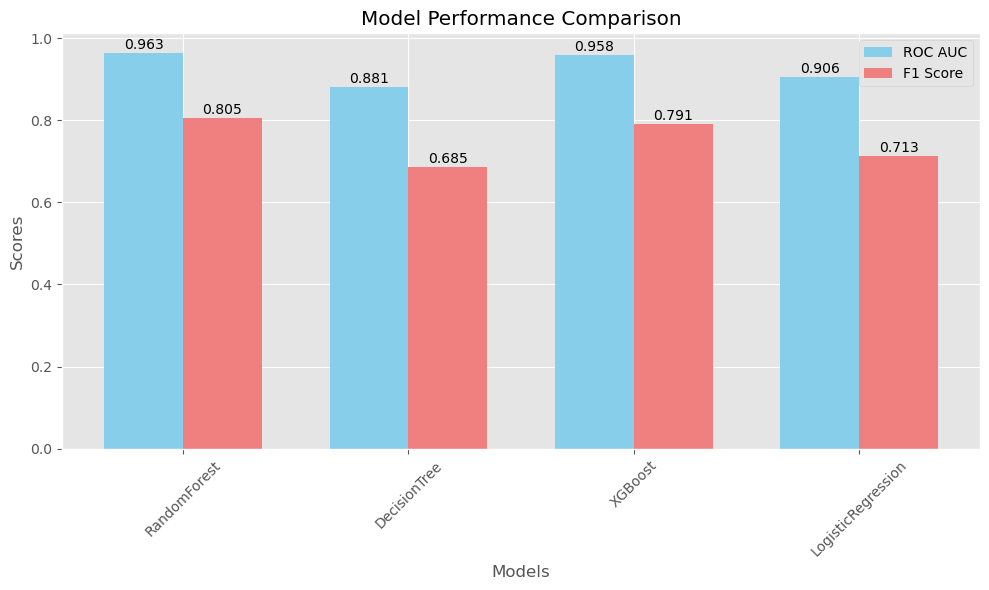

In [72]:
# Collect metrics
model_names = list(results.keys())
roc_auc_scores = [results[name]['roc_auc'] for name in model_names]
f1_scores = [results[name]['f1_score'] for name in model_names]

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(model_names))
width = 0.35
ax.bar(x - width/2, roc_auc_scores, width, label='ROC AUC', color='skyblue')
ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
for i, (roc, f1) in enumerate(zip(roc_auc_scores, f1_scores)):
    ax.text(i - width/2, roc + 0.01, f'{roc:.3f}', ha='center')
    ax.text(i + width/2, f1 + 0.01, f'{f1:.3f}', ha='center')
plt.tight_layout()
plt.show()

## Step 6: Make Final Predictions

Select the best model based on ROC-AUC and predict on the test set.

In [74]:
# Select best model based on ROC-AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} (ROC AUC: {results[best_model_name]['roc_auc']:.4f})")

# Make predictions
predictions = best_model.predict(X_test_scaled)
probabilities = best_model.predict_proba(X_test_scaled)[:, 1]
print(f"Generated {len(predictions)} predictions")
print(f"Default rate: {(predictions == 1).mean():.4f}")

# Save predictions
output = pd.DataFrame({'Prediction': predictions, 'Probability': probabilities})
output.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'")

Best model: RandomForest (ROC AUC: 0.9633)
Generated 33000 predictions
Default rate: 0.2061
Predictions saved to 'test_predictions.csv'


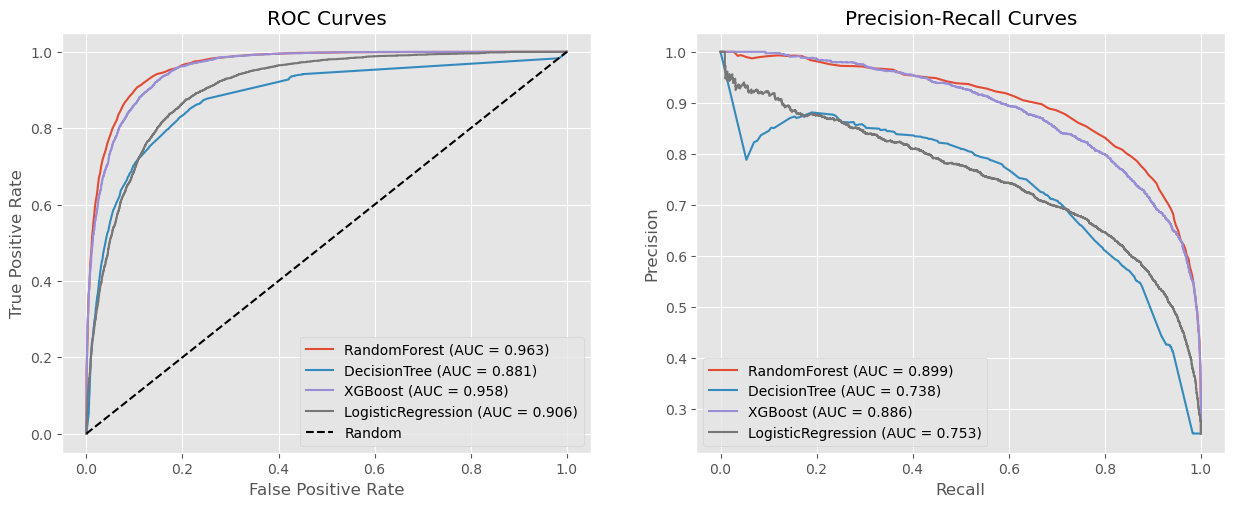

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns  # Required for heatmap; ensure seaborn is installed
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np
import pandas as pd

# Set up the plotting style (use 'ggplot' or another valid matplotlib style if seaborn is unavailable)
plt.style.use('ggplot')  # Fallback style; alternatively, use 'seaborn-v0_8' if seaborn is installed

# Create a figure with subplots
fig = plt.figure(figsize=(15, 12))

# 1. ROC Curve
plt.subplot(2, 2, 1)
for name, model in best_models.items():
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)

# 2. Precision-Recall Curve
plt.subplot(2, 2, 2)
for name, model in best_models.items():
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)

# # Display all plots
# plt.suptitle('Model Evaluation Plots', fontsize=16, y=1.05)
plt.show()

##  Conclusion: Credit Default Prediction – Validation Summary

As part of the initiative to improve credit default prediction, four models were trained and evaluated on a time-sensitive validation set derived from customer behavioral and profile data. The objective is to build a model that significantly outperforms the current production system by maximizing recall and precision on the minority class (defaults), while maintaining strong overall performance.

###  Model Performance Overview

| Metric            | Random Forest | XGBoost | Decision Tree | Logistic Regression |
|-------------------|---------------|---------|----------------|----------------------|
| **Accuracy**      | **0.91**      | 0.90    | 0.85           | 0.83                 |
| **ROC AUC**       | **0.9633**    | 0.9576  | 0.8808         | 0.9057               |
| **F1 Score (1)**  | **0.8049**    | 0.7906  | 0.6855         | 0.7134               |
| **Precision (1)** | **0.85**      | 0.82    | 0.75           | 0.63                 |
| **Recall (1)**    | 0.76          | **0.76**| 0.63           | **0.82**             |

### 🔍 Key Observations

- **Random Forest** outperforms all other models in terms of **ROC AUC (0.9633)** and **F1-score (0.8049)**, reflecting strong discriminatory power and a good balance between precision and recall for the minority (default) class.
- **XGBoost** trails closely behind and may offer faster inference times or additional flexibility during tuning, though it slightly underperforms Random Forest on most metrics.
- **Logistic Regression**, while simple and interpretable, struggles with **low precision** (0.63), meaning a high rate of false positives - an undesirable trait for production use.
- **Decision Tree** underperforms across all metrics, indicating it is too simplistic to capture the complexity of the data.

### Final Recommendation

Given the **high F1-score, precision, and ROC AUC**, the **Random Forest classifier** currently stands as the best candidate to challenge the existing production model. Its ability to effectively distinguish between defaulters and non-defaulters suggests potential to improve customer experiences by:

- Reducing false rejections (approving more good customers),
- Minimizing credit losses (accurately identifying defaulters), and
- Enhancing model trust through better recall/precision trade-off.

To further improve model performance and robustness:

- Additional **feature engineering** (e.g., aggregations over time windows, trend encoding),
- **Hyperparameter tuning**, and
- Exploring **ensemble strategies** between Random Forest and XGBoost

are recommended.

> By continuing this approach, our model could meaningfully contribute to a smarter, fairer credit approval system at industrial scale, potentially influencing the financial institution.
